In [2]:
import pickle, os, glob
import numpy as np
import matplotlib.pyplot as plt

In [18]:
path = "C:\Data\SiPM\FBK-HD5\picoscope_data"
filename_list = ["TEST_3.pkl"]#, "Am241_vb_28V_coated_scint_x0_y0.pkl"] #,"Am241_vb_29V_*.pkl",]
save_str = ["HD5"]
ov_list = [32]
data_time = [1] ## acquisition time in minutes

In [19]:
ovs_dict = {}
for j,filename in enumerate(filename_list):
    
    curr_files = glob.glob(os.path.join(path, filename))

    data_dict = {}
    wfidx = 0
    for cidx, cf in enumerate(curr_files):
        if(cidx > 0): break
        
        with open(cf, 'rb') as fin:
            curr_dict = pickle.load(fin)

            for k in curr_dict.keys():
                if k == 'time': continue
                data_dict[wfidx] = curr_dict[k]
                wfidx += 1

    nwaveforms = wfidx
    print("Got %d waveforms"%nwaveforms + " for %d files: "%len(curr_files) + filename)
    data_dict['time'] = curr_dict['time']

    ovs_dict[ov_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict}


Got 10000 waveforms for 1 files: TEST_3.pkl


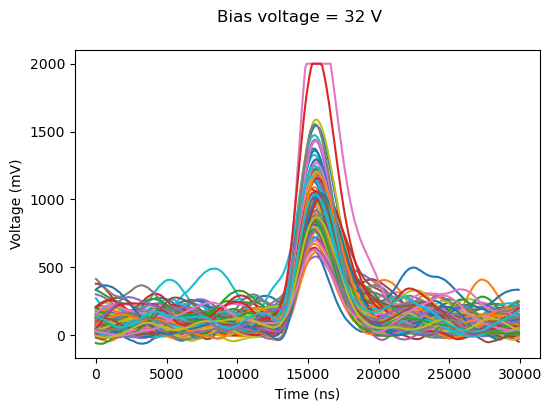

In [20]:
make_plot = True
max_figs = 100

for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    if(nwaveforms > max_figs):
        downsamp = int(nwaveforms/max_figs)
    else:
        downsamp = 1

    if(make_plot):

        plt.figure(figsize=(6,4))
        #plt.subplot(1,2,1)
        #for j in range(nwaveforms):
        #    if(j%downsamp != 0): continue
        #    plt.plot(data_dict['time'], data_dict[j][0])
        #    plt.xlabel('Time (ns)')
        #    plt.ylabel('Voltage (mV)')

        #plt.subplot(1,2,2)
        for j in range(nwaveforms):
            if(j%downsamp != 0): continue
            plt.plot(data_dict['time'], data_dict[j][1])
            plt.xlabel('Time (ns)')
            plt.ylabel('Voltage (mV)')

        plt.suptitle("Bias voltage = %s V"%str(ov))



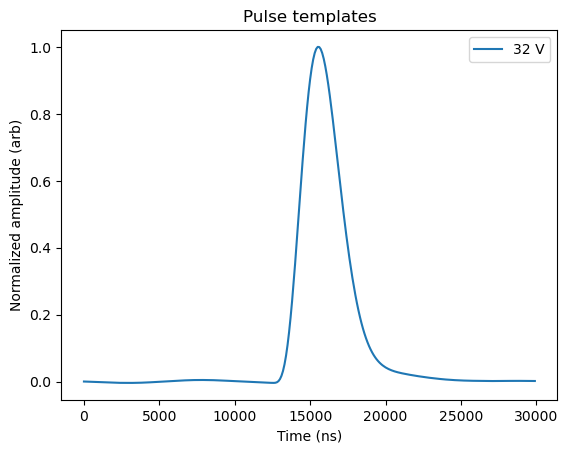

In [21]:
template_dict = {}

plt.figure()
for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    ## make average template
    template = np.zeros_like(data_dict['time'])

    nwfm = 0
    for j in range(nwaveforms):

        cdat = data_dict[j][1]

        ## throw out bad traces
        #if np.max(cdat) < 600:
        #    continue

        template += cdat
        nwfm += 1

    template /= nwfm
    template -= np.median(template[:100])
    template /= np.max(template)

    plt.plot(data_dict['time'], template, label="%s V"%str(ov))
    plt.xlabel('Time (ns)')
    plt.ylabel('Normalized amplitude (arb)')

    template_dict[ov] = template

plt.title("Pulse templates")
plt.legend()
plt.show()

working on file:  C:\Data\SiPM\FBK-HD5\picoscope_data\TEST_3.pkl


C:\Users\nEXO\AppData\Local\Temp\ipykernel_19012\743284026.py:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)


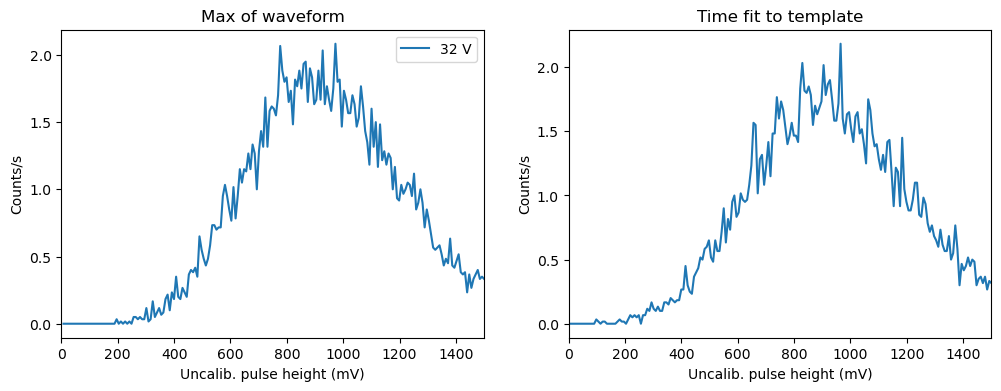

In [24]:
plt.figure(figsize=(12,4))
remake_files = True
for oidx, ov in enumerate(ov_list):

    if(remake_files):

        window  = [12500, 17500]

        curr_files = glob.glob(os.path.join(path, filename_list[oidx]))

        recon_amps = []

        wfidx = 0
        for cidx, cf in enumerate(curr_files):
            if(cidx > 100): break
            print("working on file: ", cf)
            
            with open(cf, 'rb') as fin:
                data_dict = pickle.load(fin)

                mpts = (data_dict['time']>window[0]) & (data_dict['time']<window[1])

                for k in data_dict.keys():
                    if k == 'time': continue

                    cdat = data_dict[k][1]
                    
                    ## baseline subtract
                    cdat -= np.median(cdat[:50])

                    fit = np.sum( cdat*template_dict[ov] ) / np.sum(template_dict[ov]**2)

                    midx = np.argmax(np.abs(cdat[mpts]))
                    max_val = cdat[mpts][midx]
                    recon_amps.append( [max_val, fit] )

                    wfidx += 1
        nwaveforms = wfidx
        recon_amps = np.array(recon_amps)

        np.savez( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)), recon_amps=recon_amps,nwaveforms=nwaveforms)
    else:
        data = np.load( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)) )
        recon_amps = data['recon_amps']
        nwaveforms = data['nwaveforms']
    

    bins = np.linspace(0,1500,200)
    bc = bins[:-1] + np.diff(bins)

    norm = data_time[oidx]*60

    h_max, be = np.histogram( recon_amps[:,0], bins=bins )
    h_fit, be = np.histogram( recon_amps[:,1], bins=bins )

    if('bkg' in str(ov)): 
        continue

    plt.subplot(1,2,1)
    plt.plot(bc, h_max/norm, label="%s V"%str(ov))
    plt.xlim(0,1500)
    plt.xlabel("Uncalib. pulse height (mV)")
    plt.ylabel("Counts/s")
    plt.title("Max of waveform")

    plt.subplot(1,2,2)
    plt.plot(bc, h_fit/norm)
    plt.xlabel("Uncalib. pulse height (mV)")
    plt.ylabel("Counts/s")
    plt.xlim(0,1500)
    plt.title("Time fit to template")

plt.subplot(1,2,1)
plt.legend()
plt.show()

No handles with labels found to put in legend.


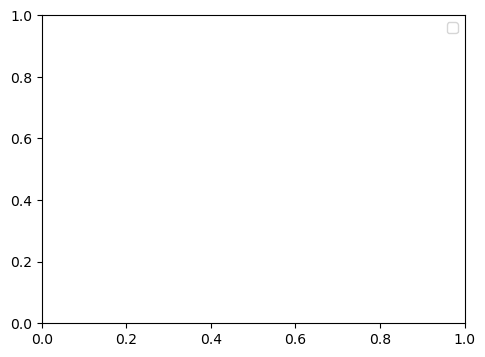

In [15]:
plt.figure(figsize=(12,4))
spec_list = []
for oidx, ov in enumerate(ov_list):

    data = np.load( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)) )
    recon_amps = data['recon_amps']
    nwaveforms = data['nwaveforms']
    

    bins = np.linspace(0,500,200)
    bc = bins[:-1] + np.diff(bins)

    norm = data_time[oidx]*60

    h_max, be = np.histogram( recon_amps[:,0], bins=bins )
    h_fit, be = np.histogram( recon_amps[:,1], bins=bins )

    if('28' not in str(ov)): 
        continue

    spec_list.append(h_max)

    plt.subplot(1,2,1)
    plt.semilogy(bc, h_max/norm, label="%s V"%str(ov))
    plt.xlim(0,400)
    plt.xlabel("Uncalib. pulse height (mV)")
    plt.ylabel("Counts/s")
    plt.title("Max of waveform")

    plt.subplot(1,2,2)
    plt.semilogy(bc, h_fit/norm)
    plt.xlabel("Uncalib. pulse height (mV)")
    plt.ylabel("Counts/s")
    plt.xlim(0,250)
    plt.title("Time fit to template")

plt.subplot(1,2,1)
plt.legend()
plt.show()

Total counts/s : 0.0


C:\Users\yalem\AppData\Local\Temp\ipykernel_1548\367766137.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xlim(0,400)


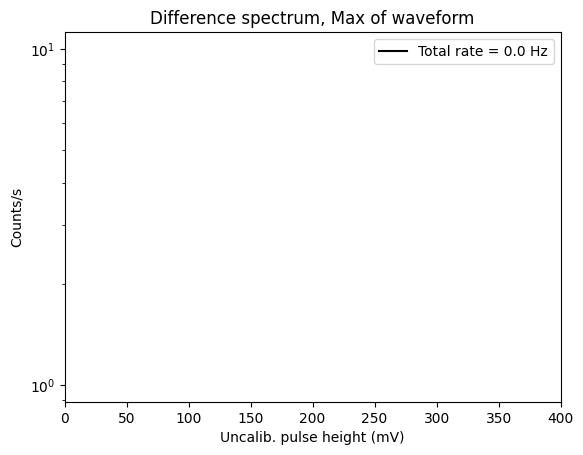

In [16]:
plt.figure()
norm2 = np.max(spec_list[1])/np.max(spec_list[0])

diff_spec = spec_list[0]*norm2 - spec_list[1]

rate = np.trapz(diff_spec/norm)
print("Total counts/s :", rate)

plt.semilogy(bc, diff_spec/norm, 'k', label="Total rate = %.1f Hz"%rate)
plt.xlim(0,400)



plt.xlabel("Uncalib. pulse height (mV)")
plt.ylabel("Counts/s")
plt.title("Difference spectrum, Max of waveform")
plt.legend()
plt.show()